# Improved Retrieval

In [3]:
import alias
import alias.injection as inj
import alias.continuum_normalization as cn

import matplotlib.pyplot as plt
import scipy.signal

import numpy as np
from astropy.io import fits

import random as rand

import tqdm.autonotebook as tqdm

plt.rcParams.update({'font.size': 10})

In [4]:
with open('../data/sample_star_urls', 'r') as f:
    urls = f.read().splitlines()

files = [ '../data/spectra/%s' %url.split('/')[-1] for url in urls ]

ds = alias.loadDataset(files)

/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/alias/__init__.py:57: RuntimeWarning: divide by zero encountered in power
  spec_ivar_parts = np.array(hdul[2].data)**-2


In [6]:
# Injection Testing Framework

def create_laser_signature(wave, lsf, idx):
    line = np.interp(np.array(range(len(wave)))-idx, lsf.x, lsf.y)
    return line

def injection_test(ds, lsf, detector, count, min_amp, max_amp):
    results = []

    for i in tqdm.trange(count):
        
        spec = rand.randrange(len(ds.flux))
        valid_idx = np.nonzero(~np.isnan(ds.flux[spec]))[0]
        idx_int = np.random.choice(valid_idx)
        idx = idx_int + np.random.uniform(-0.5, 0.5)
        wave = np.interp(idx, range(len(ds.wave)), ds.wave)
        amp = np.random.uniform(min_amp, max_amp)

        nflux = np.copy(ds.flux[spec])
        nflux += create_laser_signature(ds.wave, lsf, idx)*amp
        
        detections = detector(ds.wave, nflux, ds.ivar[spec])

        if len(detections) == 0:
            results.append((spec, idx, amp, 0, 0, 0, 0))
            continue

        detection_wavelengths = detections[:,0]
        detection_amplitudes = detections[:,1]

        detec_id = np.argmin(np.abs(detection_wavelengths - wave))
        delta_wave = detection_wavelengths[detec_id] - wave

        if np.abs(delta_wave) > 1:
            results.append((spec, idx, amp, 0, 0, 0, len(detections)))
            continue
        
        delta_flux = detection_amplitudes[detec_id] - amp
        results.append((spec, idx, amp, 1, delta_wave, delta_flux, len(detections) - 1))

    return np.array(results, dtype=float)

## Implementing Retrieval

First we must create a spectrum with an injected signal. The signal is injected between pixels to test sub-pixel retrieval.

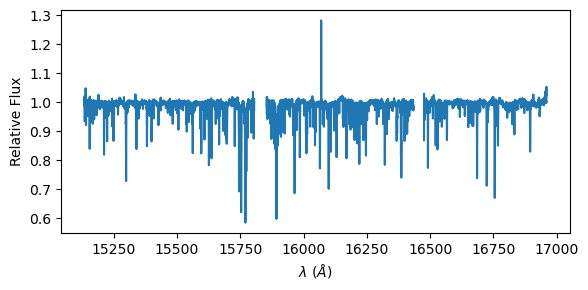

In [19]:
lsf = inj.default_lsf
test_laser_signature = np.interp(np.array(range(len(ds.wave)))-4500.3, lsf.x, lsf.y)

flux_injected = ds.flux[101] + 0.3 * test_laser_signature
ivar_injected = ds.ivar[101]

flux_injected_norm, ivar_injected_norm, _ = cn.continuum_normalize((flux_injected, ), (ivar_injected))
flux_injected_norm = flux_injected_norm[0]
ivar_injected_norm = ivar_injected_norm[0]

fig, ax = plt.subplots()

ax.plot(ds.wave, flux_injected_norm)

ax.set_xlabel(r'$\lambda$ ($\AA$)')
ax.set_ylabel(r'Relative Flux')

fig.set_figwidth(6)
fig.set_figheight(3)

fig.tight_layout()

Now we isolate the signal to test the algorithm.

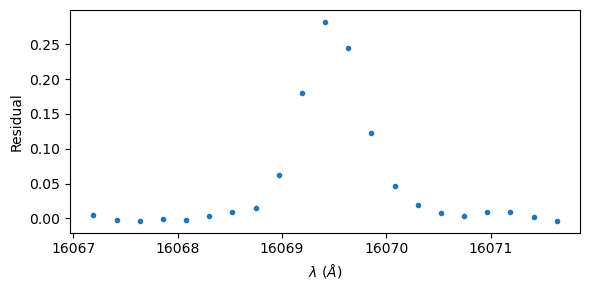

In [20]:
min = 4490
max = 4511

peak_w = ds.wave[min:max]
peak_f = flux_injected_norm[min:max] - 1 #  Subtract one to simulate using the residuals
peak_i = ivar_injected_norm[min:max]

fig, ax = plt.subplots()

ax.errorbar(peak_w, peak_f, yerr=peak_i**-0.5, fmt='.')

ax.set_xlabel(r'$\lambda$ ($\AA$)')
ax.set_ylabel(r'Residual')

fig.set_figwidth(6)
fig.set_figheight(3)

fig.tight_layout()

This function will resample the default LSF at a specific pixel position with a certain amplitude and compute the chi^2 of the fit when applied to the above spectral data.

In [21]:
def chi2_lsf(y, y_err, lsfx, lsfy, amp, center_pix):
    lsf = np.interp(range(len(y)), lsfx + center_pix, amp*lsfy)
    return np.sum(((y - lsf)/y_err)**2)

In order to find the position of minimal chi^2, we resample the LSF at several positions around the center pixel. We would know the center pixel since previous versions could reliably find the injected signal to within half of a pixel. So we can be confident that the exact location of the injection is within half of a pixel to the center point.

We first create an array of many possible points within half of a pixel of the center of the the array. We then calculate the chi^2 obtained from fitting the LSF to the signal when centered around each point. The point where is is a minimum is where the line is actually centered.

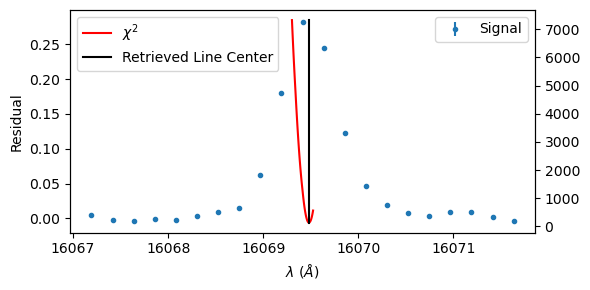

In [44]:
# Array of many possible sub-pixel line positions
center_idx = np.linspace(len(peak_w)/2 - 1, len(peak_w)/2, 64)

# Compute all chi2 for each possible position
chi2 = [ chi2_lsf(peak_f, peak_i**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), 0.3, center) for center in center_idx ]

# Find the best fit
best_idx = center_idx[np.argmin(chi2)]
best_wl = np.interp(best_idx, range(len(peak_w)), peak_w)

fig, ax = plt.subplots()

ax.errorbar(peak_w, peak_f, yerr=peak_i**-0.5, fmt='.', label='Signal')

ax.set_xlabel(r'$\lambda$ ($\AA$)')
ax.set_ylabel(r'Residual')
ax.legend()

ax2 = ax.twinx()
ax2.plot(np.interp(center_idx, range(len(peak_w)), peak_w), chi2, label='$\chi^2$', color='red')
ax2.plot((best_wl, best_wl), (np.min(chi2), np.max(chi2)), label='Retrieved Line Center', color='black')
ax2.legend(loc=2)

fig.set_figwidth(6)
fig.set_figheight(3)

fig.tight_layout()

One improvement would be more intelligently locating the minimum, possibly using something along the lines of a binary search.

Now that we have a more exact line position, we can improve the measurement of the amplitude by repeating these steps, except varying the amplitude instead of the position.

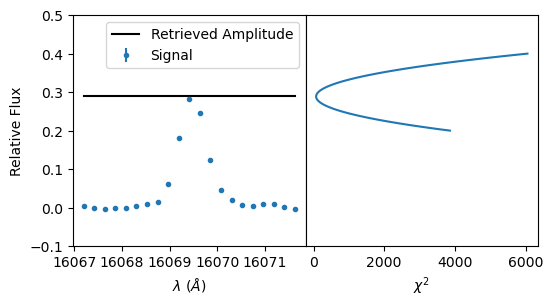

In [60]:
amps = np.linspace(0.2, 0.4, 64)

chi2 = [ chi2_lsf(peak_f, peak_i**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), amp, best_idx) for amp in amps ]

best_amplitude = amps[np.argmin(chi2)]

import matplotlib.gridspec as gridspec

fig = plt.figure()

gs = gridspec.GridSpec(1, 2, wspace=0)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.errorbar(peak_w, peak_f, yerr=peak_i**-0.5, fmt='.', label='Signal')
ax1.plot((np.min(peak_w), np.max(peak_w)), (best_amplitude, best_amplitude), color='black', label='Retrieved Amplitude')
ax1.set_ylim(-0.1, 0.5)
ax1.legend()


ax1.set_ylabel('Relative Flux')
ax1.set_xlabel('$\lambda$ ($\AA$)')

ax2.plot(chi2, amps)
ax2.set_yticks([])
ax2.set_ylim(-0.1, 0.5)

ax2.set_xlabel('$\chi^2$')

fig.set_figwidth(6)
fig.set_figheight(3)

Now we can aggregate this algorithm into a single function that can narrow down approximate wavelengths and amplitudes.

In [71]:
def improve_properties(wave, flux, ivar, amp):
    center_idx = np.linspace(len(wave)/2 - 1, len(wave)/2, 64)
    
    chi2 = [ chi2_lsf(flux, ivar**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), 0.3, center) for center in center_idx ]
    
    best_idx = center_idx[np.argmin(chi2)]
    best_wl = np.interp(best_idx, range(len(wave)), wave)

    # We can use our approximate guess of the amplitude to get a range to look for an improved amplitude
    amps = np.linspace(amp * 0.7, amp*1.4, 64)
    
    chi2 = [ chi2_lsf(flux, ivar**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), amp, best_idx) for amp in amps ]
    
    best_amplitude = amps[np.argmin(chi2)]

    return best_wl, best_amplitude

In [72]:
improve_properties(peak_w, peak_f, peak_i, 0.3)

(16069.47772315153, 0.29)

Now we can incorporate this into the old line detection algorithm and test it as before.

In [73]:
median_flux = np.nanmedian(cn.continuum_normalize(ds.flux, ds.ivar)[0], axis=0)

In [74]:
def accurate_detector(wave, flux, ivar):
        
    flux_norm_res = cn.continuum_normalize((flux, ), (ivar))[0][0] - median_flux
    peaks = scipy.signal.find_peaks(flux_norm_res, height = 0.05)[0]

    amplitudes = flux_norm_res[peaks]
    
    amplitudes_corrected = []
    wavelengths = []

    for peak in peaks:
        peak_w = wave[peak-10:peak+11]
        peak_f = flux_norm_res[peak-10:peak+11]
        nan_filter = np.isnan(peak_f) | np.isnan(peak_w) | np.isnan(peak_i)
        wl, amp = improve_properties(peak_w[~nan_filter], peak_f[~nan_filter], peak_i[~nan_filter], flux_norm_res[peak])
        wavelengths.append(wl)
        amplitudes_corrected.append(amp)
    
    return np.array((wavelengths, amplitudes_corrected)).T

In [75]:
results = injection_test(ds, inj.default_lsf, accurate_detector, 5000, 0.01, 0.5)

  0%|          | 0/5000 [00:00<?, ?it/s]

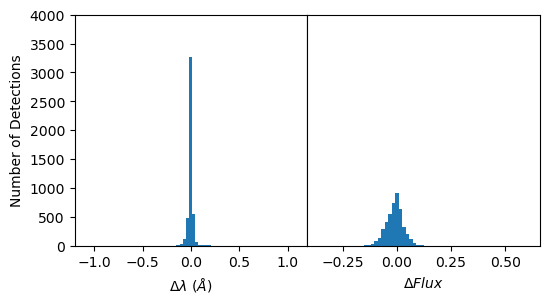

In [78]:
fig = plt.figure()

gs = gridspec.GridSpec(1, 2, wspace=0)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.hist(results[results[:,3] > 0.5,4], bins=60)

ax1.set_ylim(0, 4000)
ax1.set_xlim(-1.2, 1.2)

ax1.set_xlabel('$\Delta\lambda$ ($\AA$)')
ax1.set_ylabel('Number of Detections')

ax2.hist(results[results[:,3] > 0.5,5], bins=60)
ax2.set_ylim(0, 4000)
ax2.set_yticks([])

ax2.set_xlabel('$\Delta Flux$')

fig.set_figwidth(6)
fig.set_figheight(3)